In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")
def show_figure(path,txt,size=12,axis_off=True):
    imobj=mpimg.imread(path)
    if size:
        fig = plt.figure(figsize= (size,size)) #create an empty figure to plot into with 20x20 size
    imgplot = plt.imshow(imobj,interpolation='none')
    if axis_off:
        plt.axis('off')
    plt.title(txt,fontsize=20)
    plt.show()

## Title
De(warp/nois)ing images with a conditional GAN

## Participants
Abhishek Bhatia, Derek Novo
ab4460, dnn2109

## Project Contributions
Abhishek:
1. Use tsne analysis for visualizing the generator's learning process. 
2. Logged the loss function for plots.
3. Experimented with network architectures.
4. Tried out different patch-sizes.
5. Wrote some of code for visualization of activations. 
6. Wrote code for visualizing outputs.
7. Ran code on AWS instances
8. Wrote helper scripts for converting the images to .hdfs file, passing cmdline arguments etc.

Derek:
1. Added code for the Severing U-skip connections, 
2. Created  loads in trained weights to visualize outputs for all encoder layers for a user-specified generator type and epoch (weights saved for every 50th epoch). 
3. Created databases.
    a. Preprocessing images - typecasting and making dimensionality consistent.
    b. Wrote code for the different types of warping.
4. Helped debug.
5. Wrote helper scripts for various tasks.
6. Ran code on AWS instances



Note: 
1. Even when coding separately, we frequently ran into issues and the other participant helped us.  
2. All ideas for analysis were discussed together, which helped us in selecting better ones due to time required to ran the code for experiments.
3. Jointly debugged and modelled initial architectures.
4. All Analysis was observed and intrepreted jointly. 
5. The databases to be used were jointly discussed.





## Objectives
In recent literature, conditional GANs have been used to perform image-to-image translation tasks with image pairs $\{x,y\}$. The main objective of these tasks is to train a generator $G$ to map from the distribution of $x$ to the distribution of $y$. Unlike a traditional GAN model, conditional GANs (cGANs) [Mirza, 2014] train generators with two inputs -- a latent noise vector $z$ and one half of an image pair $x$ (to condition on) -- to output an image close to the distribution $p_{data}(y)$ of the other half of the image pairs $y$; i.e., $G(x,z) \, : \, \{x,z\} \, \rightarrow \hat{y}$. 

To the best of our knowledge, the image  pairs used in the literature have the added advantage of being structurally aligned. That is, when the two images in a pair are superimposed, many of their structural features (e.g., edges and corners) overlap. In this project, we aim to use a conditional GAN to train a generator to learn a mapping between image pairs that are much less structurally aligned. Specifically, we created two datasets: one pair of which we applied barrel distortion $(\{x, barreldistort(x)\})$, and one of which we cut out a small region of the image $(\{x, cutout(x)\})$. 

We found that a baseline cGAN does a reasonable job dewarping/denoising low spatial frequency components in the image, but blurs out high spatial frequency components. Thus, our focus was to explore the space of hyperparameters in hopes of finding some combination of these parameters that reasonably model all spatial frequency components.

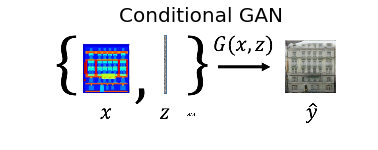

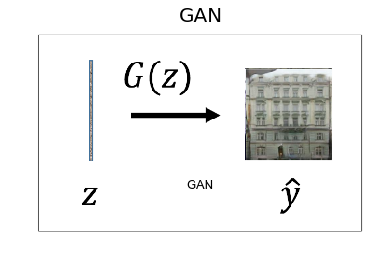

In [2]:
show_figure("./analysis/conditionalGan.png","Conditional GAN",None)
show_figure("./analysis/Gan.png","GAN",None)

## Loss

The loss function of a cGAN has two terms, L1 loss and conditional GAN loss. Formally the total loss is 

$$\mathcal{L} = \mathcal{L}_{cGAN}(G,D) + \lambda \mathcal{L}_{L1}(G),$$

where the first term is a conditional GAN $\mathcal{L}_{cGAN}(G,D) = \mathbb{E}_{x,y \sim p_{data}(x,y)}[\log{D(x,y)}] + \mathbb{E}_{x \sim p_{data}(x), z \sim p_z(z)}[\log{(1-D(x,G(x,z)))}]$ and the second term is L1 loss $\mathcal{L}_{L1}(G) = \mathbb{E}_{x,y \sim p_{data}(x,y), z \sim p_z(z)}[||y-G(x,z)||_1]$. 

The final objective function is 

$$G^* = \text{arg}\underset{G}{\operatorname{min}}\underset{D}{\operatorname{max}} \mathcal{L}_{cGAN}(G,D) + \lambda \mathcal{L}_{L1}(G)$$

## Image to Image translation problems

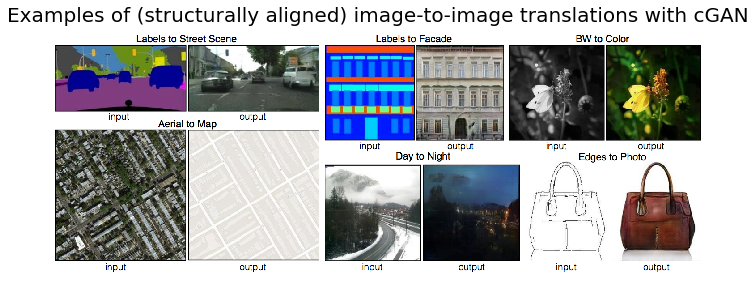

In [3]:
show_figure('./analysis/example_img2img.png','Examples of (structurally aligned) image-to-image translations with cGAN')

In recent literature, conditional gans have been used for image-to-image translation task [Tyle, 2013]
[Russakovsky, 2015], [Zhu, 2016], [Grauman, 2014], [Xie, 2015], [Eitz, 2012], [Laffont, 2014]. Below are a few examples from a recent paper that used cGANS to translate pairs. However, in the literature we’ve read, the image pairs have the added advantage of being structurally aligned. Meaning if we superimpose the two images in a pair, much of their structure (e.g., edges and corners) will overlap. This advantage helps guide the model such that it is mostly tasked with hallucinating content that is within regions bounded by these overlapping structures. In this project we aim to train the generator to learn a translation between less structured pairs (e.g., radial distortion, tangential distortion, and cut out regions).

## Database
We created all of the databases using matlab. We downloaded approximately 600 images from the $\href{}{}$McGill Colour Calibrated Database [Olmos, 2011] which contains outdoor scenes (viz., snow, foliage, landscape, flowers, and animals). Each of these images were blurred and subsampled to a 256 by 256 px image. 

$\underline{Radial Distortion}$
We created a database of which we applied barrel distortion to the images. For each image pair, each pixel was distorted by 

$$(x_d,y_d) = (x_u r + \alpha x_u r^2, y_u r + \alpha y_u r^2),$$

$$r = \sqrt{(x_\mathrm{u}-x_\mathrm{c})^2 + (y_\mathrm{u}-y_\mathrm{c})^2},$$

where $(x_u,y_u)$ are the undistorted pixels, $(x_d, y_d)$ are the distorted pixel locations, $\alpha \sim \mathcal{N}(10^{-5},10^{-6})$, and $(x_c,y_c)   \sim\ \mathcal{N}\left([w/2 \,\, h/2]^T,\, \left[ \begin{smallmatrix} 20px&0\\ 0&20px \end{smallmatrix} \right]\right)$.

$\underline{Tangential Distortion}$

We created a database of which we applied tangential distortion. For each image pair, each pixel was distorted by

$$\theta_d = \theta_u + [U(-25 \times 10^{-4},25 \times 10^{-4})r]^3,$$

where $U(a,b)$ is a uniform distribution between $a$ and $b$, $\theta_u$ is the undistorted angular coordinate with pole $(x_c,y_c)   \sim\ \mathcal{N}\left([w/2 \,\, h/2]^T,\, \left[ \begin{smallmatrix} 20px&0\\ 0&20px \end{smallmatrix} \right]\right)$ and polar axis horizontal and pointing right.

$\underline{Inpainting}$

For the image pairs which we try to train the generator to fill in a region cut out from the original, we cut out a $35 \times 35$ box with center $(w/2 + U(-12px,12px), h/2 + U(-12px,12px))$.

$\underline{Unused \, Databases}$

Difference image: We created a database that has image pairs $\{x-barreldistort(x),barreldistort(x)\}$. Since $barreldistort(x)$ and $x-barreldistort(x)$ are much more structurally aligned than $x$ and $barreldistort(x)$, we created this database hoping that $G(x,z) \approx x - barreldistort(x)$, which we would then add back $barreldistort(x)$ to $G(x,z)$ to approximate $x$. However, training the generator to translate this pair and adding back $barreldistort(x)$ had poor empirical results.





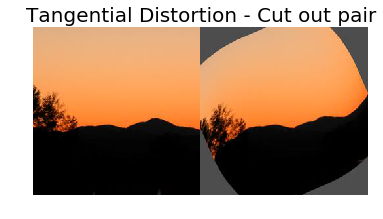

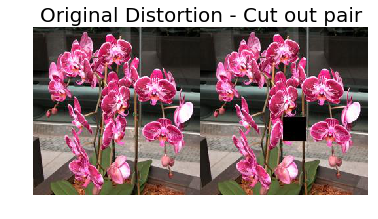

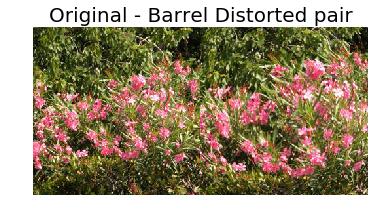

In [4]:
show_figure("./analysis/tangent.jpg","Tangential Distortion - Cut out pair",None)
show_figure("./analysis/cut_out.jpg","Original Distortion - Cut out pair",None)
show_figure("./analysis/barrel.jpg","Original - Barrel Distorted pair",None)

## Architecture

Let $\texttt{Ck}$ denote a Convolution-BatchNorm-ReLU layer with $\texttt{k}$ filters. $\texttt{CDk}$ denotes a Convolution-BatchNormDropout-ReLU layer with a dropout rate of 50%. All convolutions are 4×4 spatial filters applied with stride 2. Convolutions in the encoder, and in the discriminator, downsample by a factor of 2, whereas in the decoder they upsample by a factor of 2. 

The baseline architecture is as follows:

$\textbf{Baseline}$

$\underline{Generator}$:

Encoder: $\texttt{C64-C128-C256-C512-C512-C512-C512-C512}$

Decoder: $\texttt{CD512-CD512-CD512-C512-C512-C256-C128-C64}$

And with U-skips, the decoder concatenates activation layers, so the decoder architecture in this case becomes
Decoder: $\texttt{CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128}$

$\underline{Discriminator}$:

$\texttt{C64-C128-C256-C512-C512-C512}$

$\textbf{Deeper layered net:}$
For the deeper layered network, we used the following architecture:

Encoder: $\texttt{C64-C64-C128-C128-C256-C256-C512-C512-C512-C512-C512-C512-C512}$

The decoder is the same as the encoder but in reverse order. We did not change the shape of the discriminator.

$\textbf{Widened bottleneck}$

For the widened bottleneck, we used the same architecture as before, but added the last two layers before and after the bottleneck stride 1 instead of 2.



## Results

Note:
For 3x4 image results, shown below- the first row denotes the input distorted image, the second row displays the generator network's output and the third row shows the ground truth.

### 1. Different distortion results

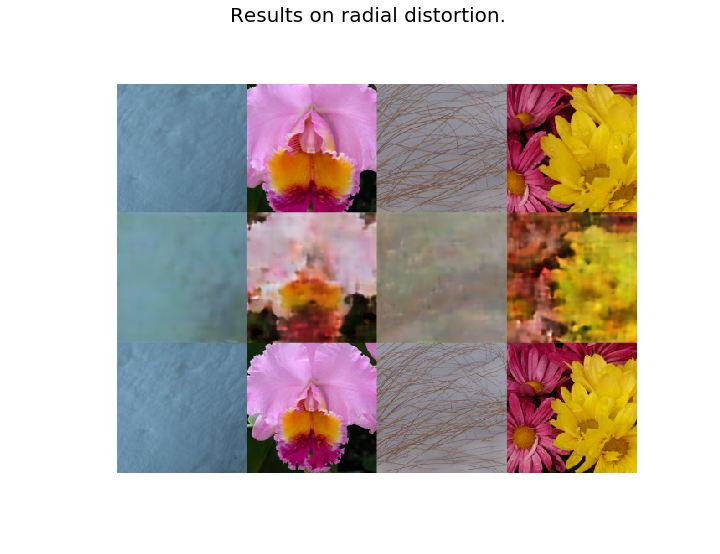

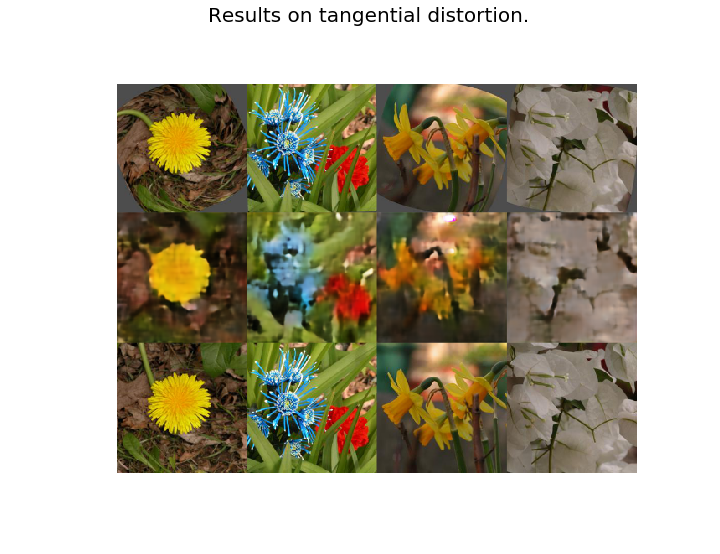

In [5]:
show_figure("./analysis/256p.png","Results on radial distortion.")
show_figure("./analysis/tangential_result.png","Results on tangential distortion.")


Above, we show initial results from network for two types of the distortions- radial and tangential. Note how the corresponding entries in the top row (distorted) and bottom row (undistorted) become much less structurally aligned as the pixel coordinates stray from the center of the image. From results, we can notice that the generator's output training though is able to retain low frequency content of the image, the high frequency content gets lost.

### 2. Image completion results

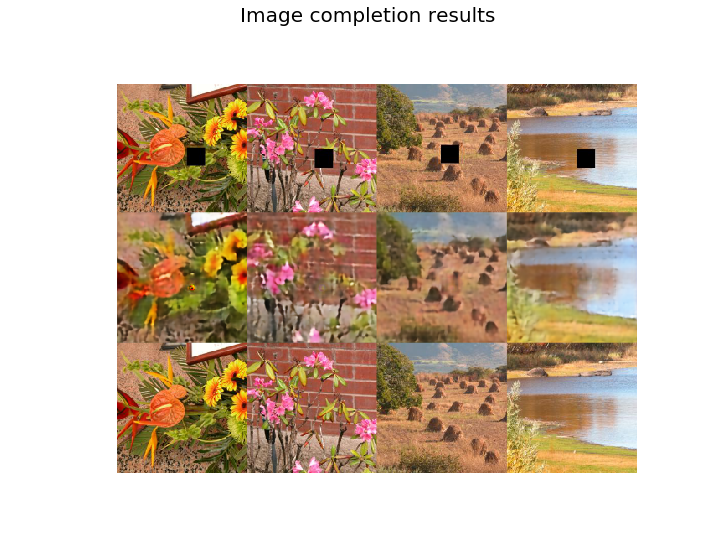

In [6]:
show_figure("./analysis/img_completion.png","Image completion results")


In the image completion problem, for a given image $I$ we cut out a small region of the image $\Omega \subset I$.
We used the same network architecture for the image completion problem. The region that the generator fills $\Omega$ has compelling low frequency information in that it appears consistent with the low frequency components of the surrounding region $I \setminus \Omega$; however,  the generated high frequency information (or lack thereof) is not consistent with the surrounding region $I \setminus \Omega$, and thus the filled-in region is blurrier than the rest of the image. That said, we are left with the same high frequency issue as with de-warping.

## Discussion on how the network handles different spatial frequencies

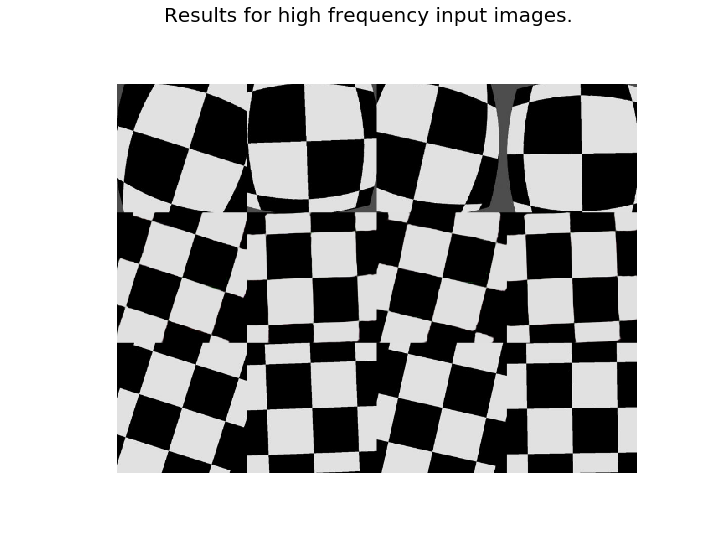

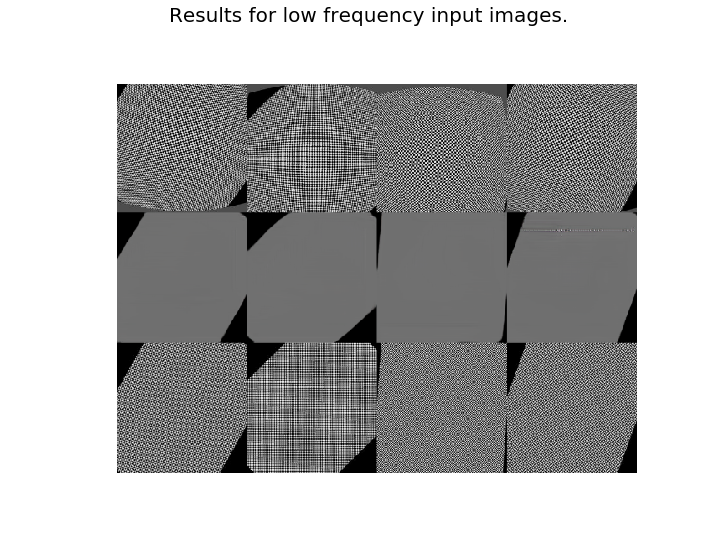

In [7]:
show_figure("./analysis/low_freq.png","Results for high frequency input images.")
show_figure("./analysis/high_freq.png","Results for low frequency input images.")


We trained the generator on a set of ~400 low spatial frequency checkerboards and ~400 high frequency checkerboards. Every example was randomly shifted and rotated. For all images (with 3 row subplots) in this notebook, the top row is $x$, the image to de(warp/noise); the middle row is $G(x,z)$, the generator's output; the bottom row is the ground truth. Here are the results for the low frequency checkerboard and high frequency checkerboard are shown above.
As aforementioned, the cGAN by itself is reasonably good at dewarping low spatial frequency components but does poorly in dewarping high spatial frequency components as shown in the results above.

## Analysis

We explored the following hyperparameters: $\lambda = \{5, 10, 100\}$, patch size (px$^2$) $=\{32 \times 32, 64 \times 64, 256 \times 256 \}$. We also changed the shape of the generator by both widening the bottleneck and making it twice as deep, as discussed before in more detail in the Architecture section. Furthermore, in order to obtain a deeper understanding of network's working we visualize activations at multiple layers, display the generator learning process in a low-dimensional embedding space, look at the variation of generated images and loss function with subsequent epochs.

### 1. Why use skip connections?


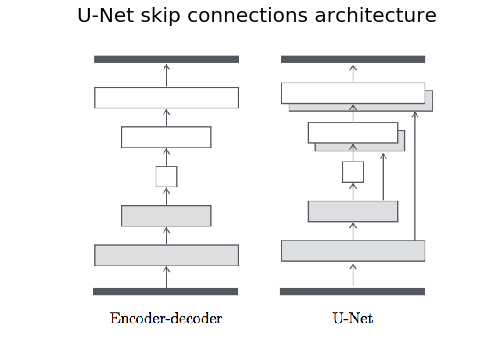

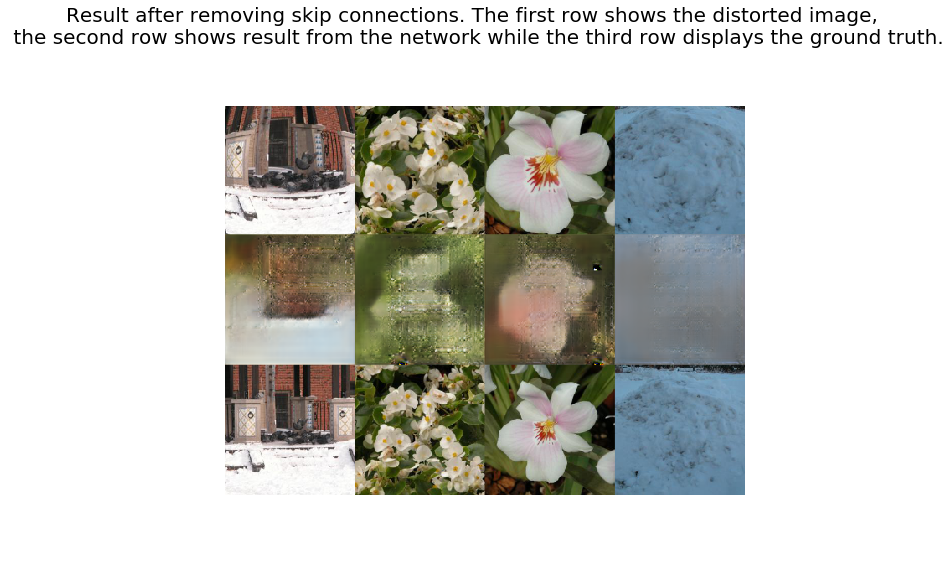

In [8]:
show_figure("./analysis/skip_connection_figure.png","U-Net skip connections architecture",8)
show_figure("./analysis/skip_connections.png","Result after removing skip connections. The first row shows the distorted image, \n the second row shows result from the network while the third row displays the ground truth.")

The generator and discriminator architectures used in the project have been adapted from [Radford, 2015].

Previous approaches to image translation problems have used encoder-decoder network [Pathak, 2016] [Wang, 2016][Johnson, 2016], whereby the input is passed through a series of layers that progressively downsample till the point a bottleneck layer is reached where the process is reversed. A network with this structure requires that all information must flow pass through all the layers. For image translation problems like ours, a significant amount of low-level information shared between the paired images needs to be shuttled through the network.
To tackle this problem, skip connections are added to circumvent the bottleneck [Ronneberger, 2015].

How our problem differs from other image translation problems is that the structure in the input image is not aligned with the structure in the output image. In order to test out the importance of such connections for our problem, we remove the two outermost connections.

As shown from the above image, significant information from the image is lost from the image when these connections are severed, thus illustrating that-- even in the context where structure differs between pairs-- such skip connections can be helpful to the network by leveraging low-level information from encoder layers.



### 2. Changing the shape of network architecture

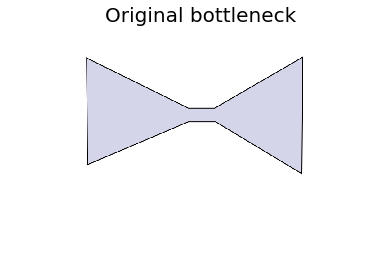

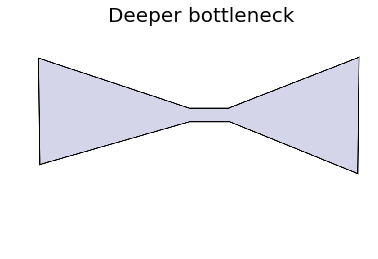

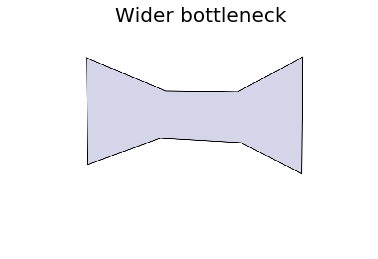

In [9]:
show_figure("./analysis/original_bottle.png","Original bottleneck",None)
show_figure("./analysis/deep_bottle.png","Deeper bottleneck",None)
show_figure("./analysis/wide_bottle.png","Wider bottleneck",None)

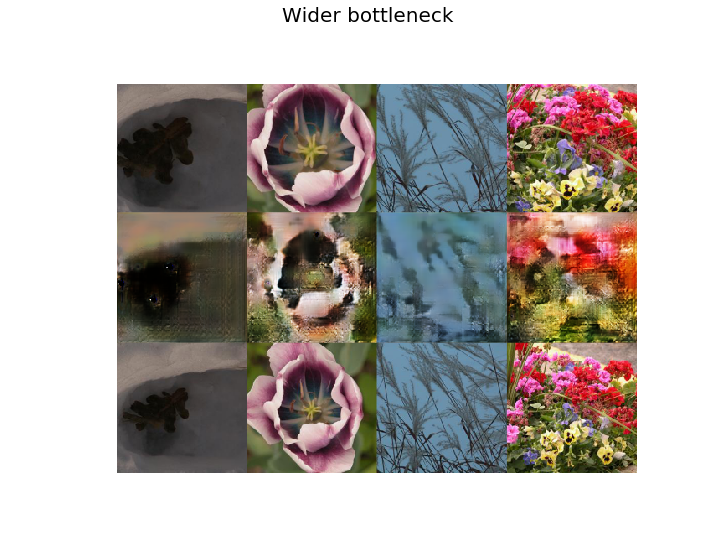

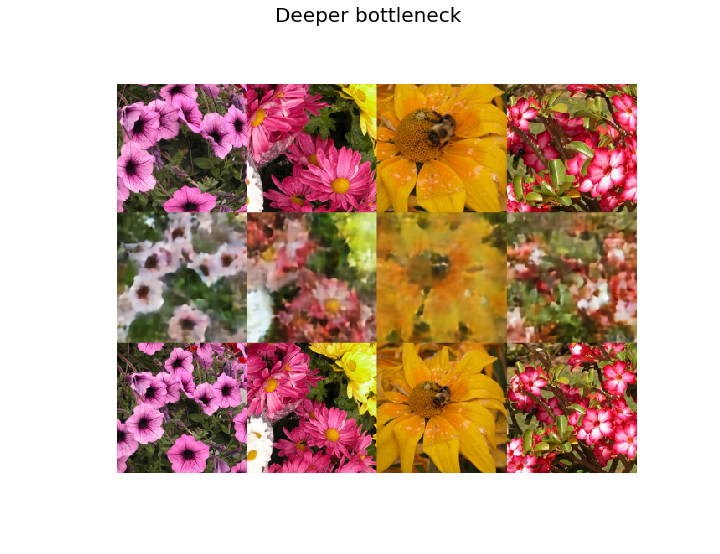

In [10]:
show_figure("./analysis/wider_result.png","Wider bottleneck")
show_figure("./analysis/deeper_result.png","Deeper bottleneck")



#### a. Increasing bottleneck size(wider network)
We experiment with increasing the size of the bottleneck, whereby we have last few layers of encoder and first few layers of the decoder to have a stride of 1. Since the M hidden units loosely correspond to M principal components in a sublinear space, increasing the width of the bottleneck should better preserve information with smaller variance in $x_1, x_2, ... , x_{256^2} \in \mathbb{R}^{256^2}$ which corresponds to higher details in the image. In other words, our motivation for this was that lesser compression would preserve the information pertaining to the structure in the image, thereby rendering harder edges in the output image.
As shown below, the output of a wider generator does well in preserving edges that locally can be interpreted as a boxcar or Heaviside function, but does poorly in preserving edges that can locally be interpreted as a Delta-like functions. (Note how the beachgrass inner edge details are not preserved, but the outer edges somewhat are.) One guess as to why this may be is that the M hidden units project onto a sub-nonlinear space, instead of sublinear representation encoded with PCA. That is, for a sub nonlinear encoded space, preserving high frequencies is not as straightforward as adding $M^*>M$ components (or hidden units) as is the case with PCA. Thus, the bottleneck size does not have a great impact on the performance of the system. Similar results were observed in [Petridis, 2016], [Ninomiya, 2015].
 


#### b. Increasing the depth of the network.
Deeper layers are known to naturally integrate more low,mid,high-level features of the input. For the purpose of making the network deeper we modified the architecture by adding more stride 1-layers in the encoder and decoder, with corresponding skip connections with respective layers. The deeper network has twice the number of layers as the previous one.
We were able to obtain sharper images, as compared to before. Thus, our results show that the network is able to preserve more structure in the image than before. However, one drawback is that we noticed some color desaturation in the output image.



### 4. Variation of patch-size

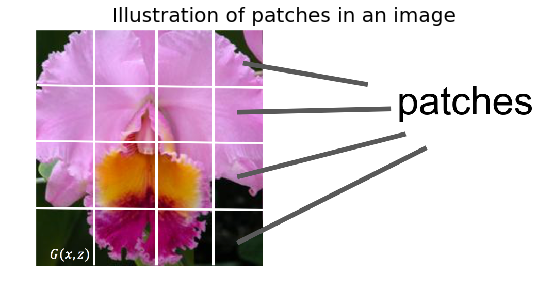

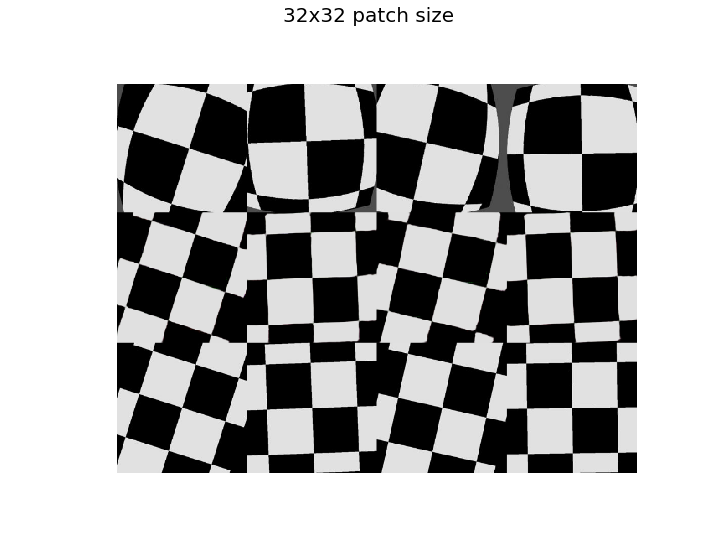

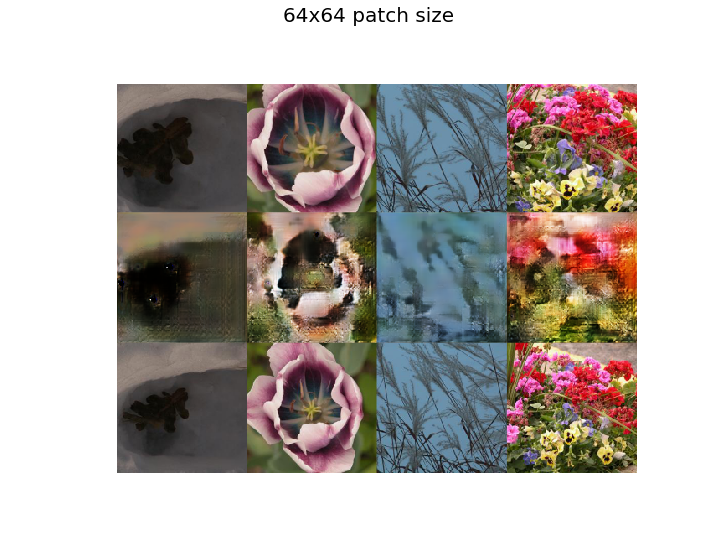

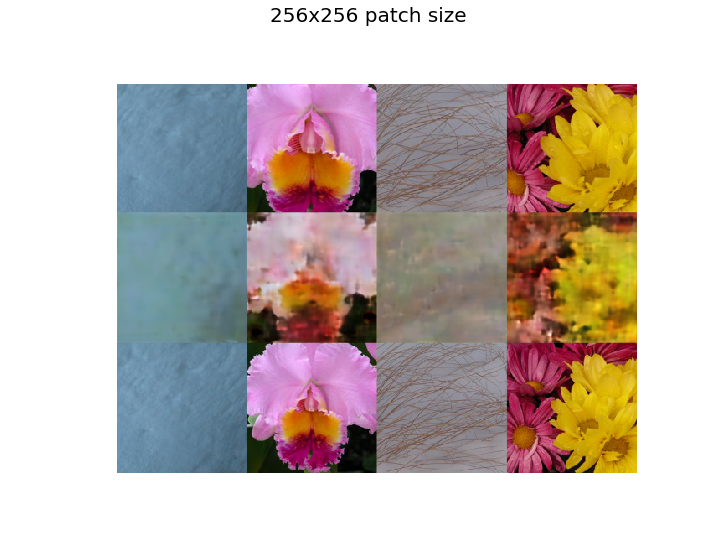

In [11]:
show_figure("./analysis/patches_illustration.png","Illustration of patches in an image",9)
show_figure("./analysis/32p.png","32x32 patch size")
show_figure("./analysis/64p.png","64x64 patch size")
show_figure("./analysis/256p.png","256x256 patch size")


In this section, we variate the patch size (px$^2$) $=\{32 \times 32, 64 \times 64, 256 \times 256 \}$.  A similar architecture on PatchGAN was previously proposed in [Li, 2016].

Since it is well known that L1 loss fails to encourage high frequency crispness but accurately models low frequencies [Larsen, 2015], we can leave the task of modeling low spatial frequencies to this term. For high frequency modeling, we can restrict the discriminator’s attention to the scale of patches. This way, the discriminator will only penalize structure for N x N neighborhood patches, instead of the entire image. 

Note how as the patch size increases, high frequency components taper off. Also note that, although high spatial frequency information is generated with smaller patches, these high frequencies are non-contextual. That is, similar high frequency components are exhibited throughout the image and are not properly localized (e.g., the building in the background [right column, middle row, 32x32 px patch] has a similar high frequency component as the flowers, although the flowers show many more high frequency components than the building in the ground truth [bottom row, right column]). This is likely due to the discriminator restrained view



### 5. Analysis of objective function with respect to L1 loss

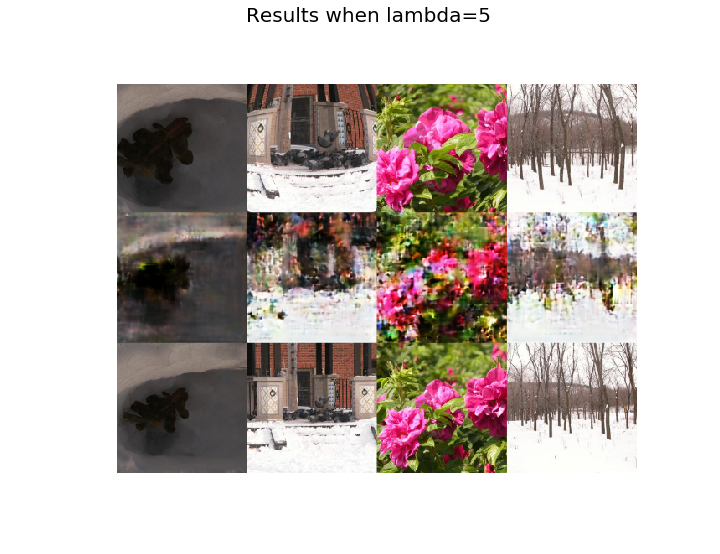

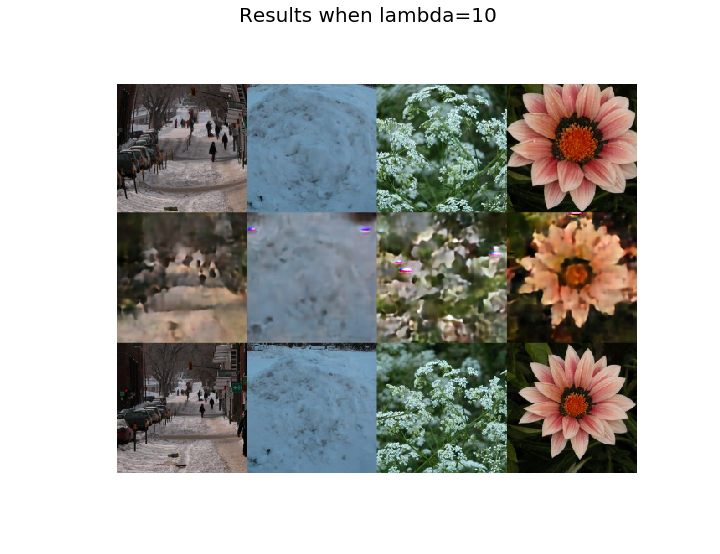

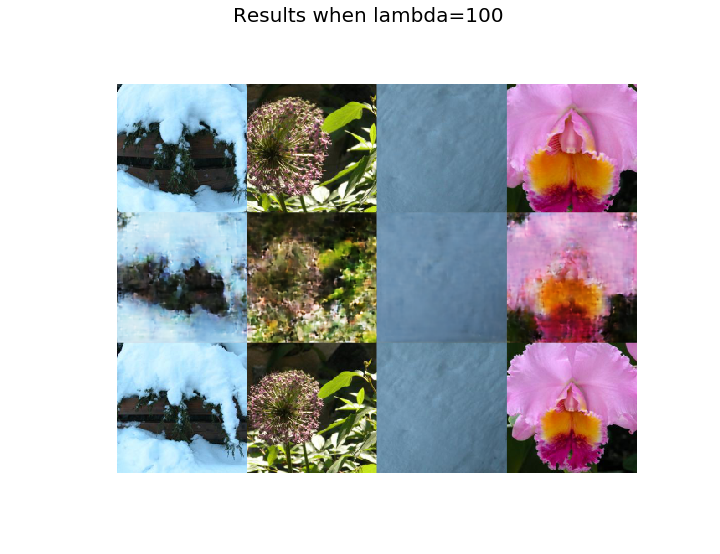

In [12]:
show_figure("./analysis/l5.png","Results when lambda=5")
show_figure("./analysis/l10.png","Results when lambda=10")
show_figure("./analysis/l100.png","Results when lambda=100")

In our loss function, we use L1 distance rather than L2 as L1 encourages less blurring. Though these loss function tend to fail in promoting high frequency crispness, in a lot of cases they nonetheless are able to accurately capture the low frequencies. In our model the GAN’s discriminator is restricted to only model high-frequency structure while we rely on an L1 term to force low-frequency correctness. Here, we test how the L1 penalty affects the final output image. We tested out different relative weights for the L1 loss. We explored the following hyperparameters: $\lambda = \{5, 10, 100\}$. We notice, by increasing lambda uncertain regions become blurry instead of having artifacts. This is consistent with the previous results [Laffont, 2014],[Isola, 2016],  where they noticed L1 alone leads to reasonable but blurry results.



### 6. Visualization of loss function

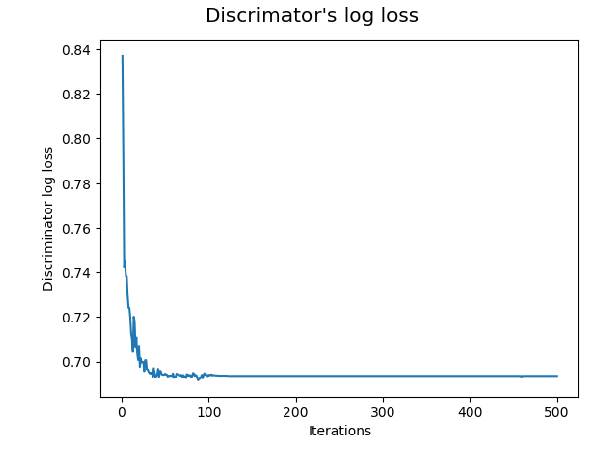

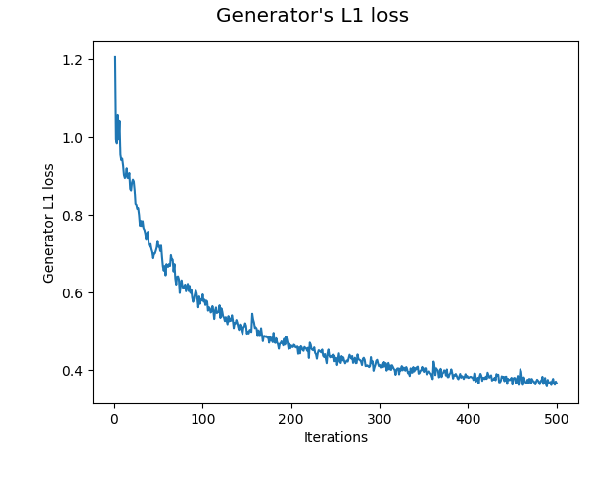

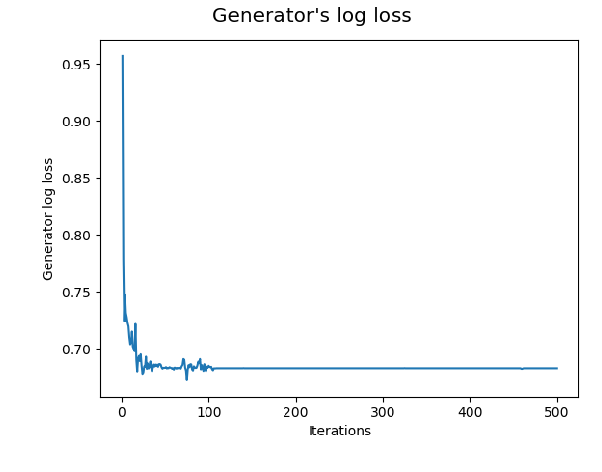

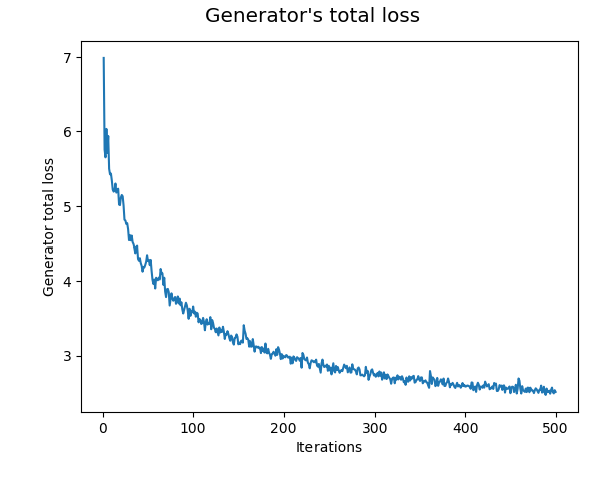

In [13]:
show_figure("./analysis/Discriminatorlogloss.png","Discrimator's log loss",10)
show_figure("./analysis/GeneratorL1loss.png","Generator's L1 loss",10)
show_figure("./analysis/Generatorlogloss.png","Generator's log loss",10)
show_figure("./analysis/Generatortotalloss.png","Generator's total loss",10)

Here, we visualize the loss functions with epochs, and draw the following observations:
* First, we notice Discriminator total loss converges faster than Generator total loss in conditional GANs. This is due to the graph that the Generator’s L1 loss takes more time to converge.
* The loss function of the generator does not decrease steadily, which can be used as a check for verifying that it is not fooling the discriminator with uncompelling images that don’t perceptually represent the sample dataset. 
* Also, we notice the generator’s L1 loss converges much more slowly than its adversarial loss. From a high level perspective, the adversarial loss encourages images that tend to look like they are from the sample distribution, and the content loss makes sure that the new generated image has similar features to the original input image.  We can visualize this better with respect to how a single sample’s output varies with epochs. This is done in “Generated images with epochs” section.





### 7. Generated images with epochs

In [14]:
'''Generator's output with epoch'''

"Generator's output with epoch"

In [15]:
from IPython.display import Image;Image(url='./analysis/animation.gif')


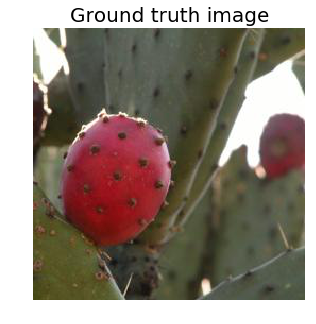

In [16]:
show_figure("./analysis/input_image.png","Ground truth image",5)


On the animation on top, here we show the Generator’s output with epochs. Below, we show the ground truth image.
As you can see in the later iterations the generator tries to learn finer grained features of the input image it is conditioned on. The content loss from the L1 penalty term makes sure that the new generated image has similar features to the original input image.


### 8. Visualizing the generator learning process


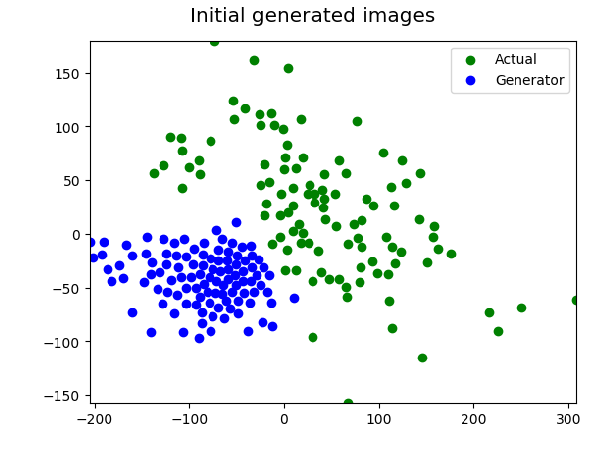

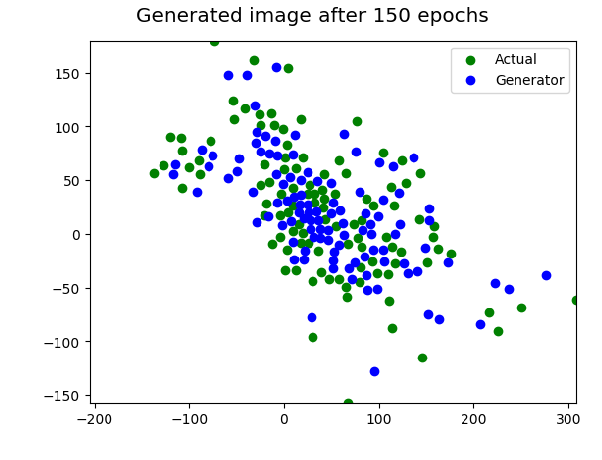

In [17]:
show_figure("./analysis/start.png","Initial generated images",10)
show_figure("./analysis/150epochs.png","Generated image after 150 epochs",10)

We use t-distributed Stochastic Neighbor Embedding [Maaten, 2008] (t-sne) to visualize how the generator is learning to output data that looks more and more like a sample from the training data.
We use this approach to map the actual and generated images down to just 2 dimensions. T-sne was run for 1000 iterations and perplexity was set to 25.
As we can see from the images, initially it is comparably easier for the discriminator to identify generated outputs from actual images. But after 150 epochs, generated output data seems much more plausible that they are sampled from the distribution of actual dataset. As a result, the discriminator has a harder time than it did in earlier epochs in telling generated and actual data apart.



### 9. Visualizing Activations


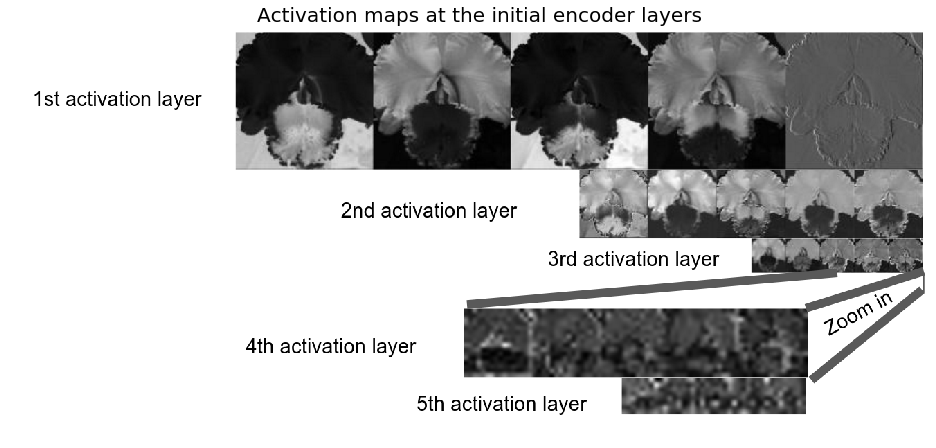

In [18]:
show_figure("./analysis/visualization.png","Activation maps at the initial encoder layers",16)


For the purpose of understanding the underlying operations of the network, it is useful to interpret the feature activity in each of the intermediate layers. In this section, we try to determine what kinds of features a convolutional network learns at each layer of the network. 
For each layer, we visualize the activations at hidden nodes which were maximally activated for a given randomly selected input sample.
From the activations in the first layer, we can see that hidden nodes identify different colored regions of the flower as well as the edges present. Subsequently, we can see the activations become more and more specific, but more difficult to gain meaningful insight. 
In the future, we hope to instead use a better method such as in [1], where the authors attach a deconvnet to each of its layers, thereby providing a continuous path back to image pixels. Then successively they unpool, rectify and filter to reconstruct the activity in the layer beneath which gave rise to the chosen activation. This process is then repeated until the input pixel space is reached. From here, the visualizations learnt are accurate representations of the input pattern which stimulates a particular selected feature map in the model.



## Future Work

A technique we did not use in this project, but could help resolve the present frequency issues, is replacing our convolutional weights and max pooling with Fourier multiplications, a.k.a. spectral pooling [Rippel, 2015]. In short, the operator duality between convolution in the spatial domain and element-wise multiplication in the spectral domain can be leveraged to preserve much more information in the downsampling stages than max pooling. Specifically, we could replace convolutional layers from the spatial domain to Fourier multiplications in the spectral domain.

Another task to explore is to train a generator to learn tranformations for image pairs with complex warping. One such transformation could be converting a scene in a photograph to the same scene but in the world of, say, The Simpsons. This type of transformation is not the same as applying Monet-/Van Gogh-/Cezanne-like brush strokes to the photograph as in [Zhu, 2017], [Johnson, 2016]  (see Fig. 6 of [2]). In order for this photorealism-to-cartoon warping to look compelling (i.e., to look like the artist of The Simpsons looked at the photograph and then drew the scene in the photograph in the style of The Simpsons), the generator would be required to model drastic changes in lines, textures, and colors. Such a task is much more ambitious than the image pairs explored in this project since we keep the textures and colors constant between pairs and only apply a comparably small amount of distortion.




## References

1. Rippel, Oren, Jasper Snoek, and Ryan P. Adams. "Spectral representations for convolutional neural networks." Advances in Neural Information Processing Systems. 2015.
2. Johnson, Justin, Alexandre Alahi, and Li Fei-Fei. "Perceptual losses for real-time style transfer and super-resolution." European Conference on Computer Vision. Springer International Publishing, 2016.
3. Zhu, Jun-Yan, et al. "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks." arXiv preprint arXiv:1703.10593 (2017).
4. Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.
5. P.-Y. Laffont, Z. Ren, X. Tao, C. Qian, and J. Hays. Transient attributes for high-level understanding and editing of outdoor scenes. ACM Transactions on Graphics (TOG), 33(4):149, 2014. 1, 4, 16
6. Isola, Phillip, et al. "Image-to-image translation with conditional adversarial networks." arXiv preprint arXiv:1611.07004 (2016).
7. A. B. L. Larsen, S. K. Sønderby, and O. Winther. Autoencoding beyond pixels using a learned similarity metric. arXiv preprint arXiv:1512.09300, 2015.
8. Petridis, Stavros, and Maja Pantic. "Deep complementary bottleneck features for visual speech recognition." Acoustics, Speech and Signal Processing (ICASSP), 2016 IEEE International Conference on. IEEE, 2016.
9. Hiroshi Ninomiya, Norihide Kitaoka, Satoshi Tamura, Yurie Iribe, and Kazuya Takeda, “Integration of deep bottleneck features for audio-visual speech recognition,” in Sixteenth Annual Conference of the International Speech Communication Association, 2015.
10. A. Radford, L. Metz, and S. Chintala. Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434, 2015.
11. D. Pathak, P. Krahenbuhl, J. Donahue, T. Darrell, and A. A. Efros. Context encoders: Feature learning by inpainting. CVPR, 2016. 2, 3
12. X. Wang and A. Gupta. Generative image modeling using style and structure adversarial networks. ECCV, 2016. 2, 3, 5
13.  J. Johnson, A. Alahi, and L. Fei-Fei. Perceptual losses for real-time style transfer and super-resolution. 2016. 2, 3
14. O. Ronneberger, P. Fischer, and T. Brox. U-net: Convolutional networks for biomedical image segmentation. In MICCAI, pages 234–241. Springer, 2015. 2, 3, 4.
15. C. Li and M. Wand. Precomputed real-time texture synthesiswith markovian generative adversarial networks. ECCV, 2016. 2, 4
16. M. Mirza and S. Osindero. Conditional generative adversarial nets. arXiv preprint arXiv:1411.1784, 2014. 2
17. M. Cordts, M. Omran, S. Ramos, T. Rehfeld, M. Enzweiler,R. Benenson, U. Franke, S. Roth, and B. Schiele. The cityscapes dataset for semantic urban scene understanding. In CVPR), 2016. 4, 16
18. Olmos, A. "Kingdom FAA (2004) McGill calibrated colour image database." URL http://tabby. vision. mcgill. ca. Last accessed (2011): 05-08.
19. R. S. Radim Tyle ˇ cek. Spatial pattern templates for recognition of objects with regular structure. In Proc. GCPR, Saarbrucken, Germany, 2013. 4, 16.
20. O. Russakovsky, J. Deng, H. Su, J. Krause, S. Satheesh, S. Ma, Z. Huang, A. Karpathy, A. Khosla, M. Bernstein, et al. Imagenet large scale visual recognition challenge. IJCV, 115(3):211–252, 2015. 4, 8, 16.
21.  J.-Y. Zhu, P. Krahenb ¨ uhl, E. Shechtman, and A. A. Efros. ¨Generative visual manipulation on the natural image manifold. In ECCV, 2016. 2, 4, 16.
22. A. Yu and K. Grauman. Fine-Grained Visual Comparisons with Local Learning. In CVPR, 2014. 4
23. S. Xie and Z. Tu. Holistically-nested edge detection. In ICCV, 2015. 1, 2, 4.
24. M. Eitz, J. Hays, and M. Alexa. How do humans sketch objects? SIGGRAPH, 31(4):44–1, 2012. 4, 12
24.  P.-Y. Laffont, Z. Ren, X. Tao, C. Qian, and J. Hays. Transient attributes for high-level understanding and editing of outdoor scenes. ACM Transactions on Graphics (TOG), 33(4):149, 2014. 1, 4, 16

The code was implemented in keras with tensorflow as backend.
Phillip Isola's implementation of pix2pix in caffe, Thibault's codebase in keras, Christopher and Yen's code for pix2pix in tensorflowwas particularly useful for reference. Additionally,  Tim O'Shea's tutorial for coding GANs in keras was helpful.

### Generator's code

In [19]:
from keras.models import Model
from keras.layers.core import Flatten, Dense, Dropout, Activation, Lambda, Reshape
from keras.layers.convolutional import Convolution2D, Deconvolution2D, ZeroPadding2D, UpSampling2D
from keras.layers import Input, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
import keras.backend as K
import numpy as np
from pprint import pprint
import pdb

def minb_disc(x):
    diffs = K.expand_dims(x, 3) - K.expand_dims(K.permute_dimensions(x, [1, 2, 0]), 0)
    abs_diffs = K.sum(K.abs(diffs), 2)
    x = K.sum(K.exp(-abs_diffs), 2)

    return x


def lambda_output(input_shape):
    return input_shape[:2]


def conv_block_unet(x, f, name, bn_mode, bn_axis, bn=True, subsample=(2,2)):
	# Convolutional block in the U-net, encoder (downsampling) half of the network.

    x = LeakyReLU(0.2)(x) # LeakyReLU(alpha) -> equals x, if x > 0; equals alpha*x, if x < 0.
    x = Convolution2D(f, 3, 3, subsample=subsample, name=name, border_mode="same")(x)
    if bn:
	# Normalize the batch along bn_axis
        x = BatchNormalization(mode=bn_mode, axis=bn_axis)(x)
                                                ## normalises across the depth

    return x


def up_conv_block_unet(x, x2, f, name, bn_mode, bn_axis, bn=True, dropout=False, should_merge=True,strides=2):
    # Convolutional up_conv_block_unetblock in the U-net. After x=ReLU(x), each pixel in x is copied and then mapped to its own 2x2 neighborhood in the output.
	# Then a convolution is done on x=UPSAMP(x). Lastly, x and x2 are merged for a U-skip, where x2 is across the U (encoder side).
    #import pdb;pdb.set_trace()
    x = Activation("relu")(x)
    x = UpSampling2D(size=(strides, strides))(x)
    x = Convolution2D(f, 3, 3, name=name, border_mode="same")(x)
    if bn:
        x = BatchNormalization(mode=bn_mode, axis=bn_axis)(x)
    if dropout:
        x = Dropout(0.5)(x)
	if should_merge:
		x = merge([x, x2], mode='concat', concat_axis=bn_axis)

    return x


def deconv_block_unet(x, x2, f, h, w, batch_size, name, bn_mode, bn_axis, bn=True, dropout=False):
	# Deconvolutional block. After x=ReLU(x), deconvolves x with output shape equal to (batch size, height, width, features).
	# Concatenates x with x2.

    o_shape = (batch_size, h * 2, w * 2, f)
    x = Activation("relu")(x)
    x = Deconvolution2D(f, 3, 3, output_shape=o_shape, subsample=(2, 2), border_mode="same")(x)
    if bn:
        x = BatchNormalization(mode=bn_mode, axis=bn_axis)(x)
    if dropout:
        x = Dropout(0.5)(x)

    x = merge([x, x2], mode='concat', concat_axis=bn_axis)

    return x


def generator_unet_upsampling(img_dim, bn_mode, model_name="generator_unet_upsampling",sever_connections=False,deep_ntwk_gen=False,wider_gen_bottleneck=False):
                            # image dimensions, batch norm mode
########### ENCODER
    nb_filters = 64

    ## theano or tensorflow conversions
    if K.image_dim_ordering() == "th":
        bn_axis = 1
        nb_channels = img_dim[0]
        min_s = min(img_dim[1:]) # img_dim[1:] outputs all elements in img_dim except for the first element.
    else:
        bn_axis = -1
        nb_channels = img_dim[-1]
        min_s = min(img_dim[:-1])

    # specifies the input format
    unet_input = Input(shape=img_dim, name="unet_input")

    # Prepare encoder filtersg16
    nb_conv = int(np.floor(np.log(min_s) / np.log(2)))
    list_nb_filters = [nb_filters * min(8, (2 ** i)) for i in range(nb_conv)]
    ## [64, 128, 256, 512, 512, 512, 512, 512]

    if deep_ntwk_gen=="True":
        list_nb_filters=[64, 64, 128,128, 256,256, 512, 512, 512, 512, 512, 512,512]

        #[64, 64, 128, 128, 256, 256, 512, 512, 512, 512, 512, 1024]
    #print list_nb_filters
    # Encoder
    strides=2
    ## first encoder with no batchnorm
    list_encoder = [Convolution2D(list_nb_filters[0], 3, 3,
                                  subsample=(strides, strides), name="unet_conv2D_1", border_mode="same")(unet_input)]
                                                                            ## unet_input is the input to the
    ## rest of encoders
    for i, f in enumerate(list_nb_filters[1:]):
        if deep_ntwk_gen=="True":
            if i %2==0 and i<=10:
                strides=1
            else:
                strides=2
        if wider_gen_bottleneck=="True":
            if i>4:
                strides=1
        name = "unet_conv2D_%s" % (i + 2)
        conv = conv_block_unet(list_encoder[-1], f, name, bn_mode, bn_axis,subsample=(strides, strides))
                            ## last encoder , filter size,...,
        list_encoder.append(conv)
    ## Note: add activation at the start of each layer instead at the end

########### DECODER
    # Prepare decoder filters
    list_nb_filters = list_nb_filters[:-2][::-1]
    ## [512, 512, 512, 256, 128, 64]

    if len(list_nb_filters) < nb_conv - 1:
        list_nb_filters.append(nb_filters)
        ## adds an extra 64 filter for some reason
        ## list_nb_filters= [512, 512, 512, 256, 128, 64, 64]


    # Decoder
    ## first decoder with no batchnorm
    if wider_gen_bottleneck=="True":
        strides=1
    else:
        strides=2

    print list_encoder[-1], list_encoder[-2]
    list_decoder = [up_conv_block_unet(list_encoder[-1], list_encoder[-2],
                                       list_nb_filters[0], "unet_upconv2D_1", bn_mode, bn_axis, dropout=True,strides=strides)]

    for i, f in enumerate(list_nb_filters[1:]):
        print list_decoder[-1], list_encoder[-(i + 3)]


    for i, f in enumerate(list_nb_filters[1:]):
        print i
        name = "unet_upconv2D_%s" % (i + 2)
        # Dropout only on first few layers
        if deep_ntwk_gen=="True":
            if i %2==0 and i<=10:
                strides=1
            else:
                strides=2
        if wider_gen_bottleneck=="True":
            if i<1:
                strides=1
            else:
                strides=2
        if i < 2:
            d = True
        elif i< 4 and deep_ntwk_gen=="True":
            d = True
        else:
            d = False
		# Sever outermost k U-skip connections
        k = 3
        if i < k and sever_connections=="True": # sever_connections whether to sever_connections or not
			sm = False                  # it is passed from the commandline
        else:
			sm = True
        conv = up_conv_block_unet(list_decoder[-1], list_encoder[-(i + 3)], f, name, bn_mode, bn_axis, dropout=d, should_merge=sm,strides=strides)
                                # last decoder, skip connection, number of filters,...,..,dropout

        list_decoder.append(conv)

    ## last decoder that maps to 3 channels using 3 filters
    x = Activation("relu")(list_decoder[-1])
    x = UpSampling2D(size=(2, 2))(x)
    x = Convolution2D(nb_channels, 3, 3, name="last_conv", border_mode="same")(x)
    x = Activation("tanh")(x)
    ## x is the output of the network
    #pprint(list_encoder)
    #pprint(list_decoder);print("")
    generator_unet = Model(input=[unet_input], output=[x])

    return generator_unet


def generator_unet_deconv(img_dim, bn_mode, batch_size, model_name="generator_unet_deconv"):

    assert K.backend() == "tensorflow", "Not implemented with theano backend"

    nb_filters = 64
    bn_axis = -1
    h, w, nb_channels = img_dim
    min_s = min(img_dim[:-1])

    unet_input = Input(shape=img_dim, name="unet_input")

    # Prepare encoder filters
    nb_conv = int(np.floor(np.log(min_s) / np.log(2)))
    list_nb_filters = [nb_filters * min(8, (2 ** i)) for i in range(nb_conv)]

    # Encoder
    list_encoder = [Convolution2D(list_nb_filters[0], 3, 3,
                                  subsample=(2, 2), name="unet_conv2D_1", border_mode="same")(unet_input)]
    # update current "image" h and w
    h, w = h / 2, w / 2
    for i, f in enumerate(list_nb_filters[1:]):
        name = "unet_conv2D_%s" % (i + 2)
        conv = conv_block_unet(list_encoder[-1], f, name, bn_mode, bn_axis)
        list_encoder.append(conv)
        h, w = h / 2, w / 2

    # Prepare decoder filters
    list_nb_filters = list_nb_filters[:-1][::-1]
    if len(list_nb_filters) < nb_conv - 1:
        list_nb_filters.append(nb_filters)

    # Decoder
    list_decoder = [deconv_block_unet(list_encoder[-1], list_encoder[-2],
                                      list_nb_filters[0], h, w, batch_size,
                                      "unet_upconv2D_1", bn_mode, bn_axis, dropout=True)]
    h, w = h * 2, w * 2
    for i, f in enumerate(list_nb_filters[1:]):
        name = "unet_upconv2D_%s" % (i + 2)
        # Dropout only on first few layers
        if i < 2:
            d = True
        else:
            d = False
        conv = deconv_block_unet(list_decoder[-1], list_encoder[-(i + 3)], f, h,
                                 w, batch_size, name, bn_mode, bn_axis, dropout=d)
        list_decoder.append(conv)
        h, w = h * 2, w * 2

    x = Activation("relu")(list_decoder[-1])
    o_shape = (batch_size,) + img_dim
    x = Deconvolution2D(nb_channels, 3, 3, output_shape=o_shape, subsample=(2, 2), border_mode="same")(x)
    x = Activation("tanh")(x)

    generator_unet = Model(input=[unet_input], output=[x])

    return generator_unet






def load(model_name, img_dim, nb_patch, bn_mode, use_mbd, batch_size,sever_connections=False,deep_ntwk_gen=False,deep_ntwk_dis=False,wider_gen_bottleneck=False):

    if model_name == "generator_unet_upsampling":
        ## define the generator model here which includes the encoder and decoder
        model = generator_unet_upsampling(img_dim, bn_mode, model_name=model_name,sever_connections=sever_connections,deep_ntwk_gen=deep_ntwk_gen,wider_gen_bottleneck=wider_gen_bottleneck)
        print model.summary()
        from keras.utils.visualize_util import plot
        #plot(model, to_file='../../figures/%s.png' % model_name, show_shapes=True, show_layer_names=True)
        return model

    if model_name == "generator_unet_deconv": ## this part is never called
        model = generator_unet_deconv(img_dim, bn_mode, batch_size, model_name=model_name)
        print model.summary()
        from keras.utils.visualize_util import plot
        #plot(model, to_file='../../figures/%s.png' % model_name, show_shapes=True, show_layer_names=True)
        return model

    if model_name == "DCGAN_discriminator":
        ## define the discriminator here
        model = DCGAN_discriminator(img_dim, nb_patch, bn_mode, model_name=model_name, use_mbd=use_mbd,
                                    deep_ntwk_dis=deep_ntwk_dis)
        model.summary()
        from keras.utils.visualize_util import plot
        plot(model, to_file='../../figures/%s.png' % model_name, show_shapes=True, show_layer_names=True)
        return model

Using TensorFlow backend.


### Discriminator's code

In [20]:

def DCGAN_discriminator(img_dim, nb_patch, bn_mode, model_name="DCGAN_discriminator", use_mbd=True,deep_ntwk_dis=False):

    ## nb_patch is 16 which maybe calculated as: (256*256)/(64*64)
    list_input = [Input(shape=img_dim, name="disc_input_%s" % i) for i in range(nb_patch)]


    if K.image_dim_ordering() == "th":
        bn_axis = 1
    else:
        bn_axis = -1

    nb_filters = 64
    nb_conv = int(np.floor(np.log(img_dim[1]) / np.log(2)))
    list_filters = [nb_filters * min(8, (2 ** i)) for i in range(nb_conv)]
    ## [64, 128, 256, 512, 512, 512]
    if deep_ntwk_dis=="True":
        list_filters= [64, 64, 128, 128, 256, 256, 512, 512, 512, 512, 512, 512]
    strides=2

    # First conv
    x_input = Input(shape=img_dim, name="discriminator_input")
    x = Convolution2D(list_filters[0], 3, 3, subsample=(strides, strides), name="disc_conv2d_1", border_mode="same")(x_input)
    x = BatchNormalization(mode=bn_mode, axis=bn_axis)(x)
    x = LeakyReLU(0.2)(x)

    # Next convs
    for i, f in enumerate(list_filters[1:]):
        name = "disc_conv2d_%s" % (i + 2)
        if i% 2==0:
            strides=1
        else:
            strides=2
        x = Convolution2D(f, 3, 3, subsample=(2, 2), name=name, border_mode="same")(x)
        x = BatchNormalization(mode=bn_mode, axis=bn_axis)(x)
        x = LeakyReLU(0.2)(x)

    x_flat = Flatten()(x)
    x = Dense(2, activation='softmax', name="disc_dense")(x_flat)
    PatchGAN = Model(input=[x_input], output=[x, x_flat], name="PatchGAN")
    print("PatchGAN summary")
    PatchGAN.summary()

    x = [PatchGAN(patch)[0] for patch in list_input]
    # list_input is of length 16
    x_mbd = [PatchGAN(patch)[1] for patch in list_input]

    if len(x) > 1:
        x = merge(x, mode="concat", name="merge_feat")
    else:
        x = x[0]

    if use_mbd:
        if len(x_mbd) > 1:
            x_mbd = merge(x_mbd, mode="concat", name="merge_feat_mbd")
        else:
            x_mbd = x_mbd[0]

        num_kernels = 100
        dim_per_kernel = 5

        M = Dense(num_kernels * dim_per_kernel, bias=False, activation=None)
        MBD = Lambda(minb_disc, output_shape=lambda_output)

        x_mbd = M(x_mbd)
        x_mbd = Reshape((num_kernels, dim_per_kernel))(x_mbd)
        x_mbd = MBD(x_mbd)
        x = merge([x, x_mbd], mode='concat')

    x_out = Dense(2, activation="softmax", name="disc_output")(x)

    discriminator_model = Model(input=list_input, output=[x_out], name=model_name)

    return discriminator_model